<a href="https://colab.research.google.com/github/haresh93/EVA-submissions/blob/master/S6/EVA4_Session_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Batch Norm and Ghost Batch Norm
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)


In [0]:
# Train and Test Transforms
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,))
])

test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
])

In [0]:
# Train and Test Datasets
train_dataset = datasets.MNIST('../data', train=True, download=True,
                    transform=train_transforms)
test_dataset = datasets.MNIST('../data', train=False, download=True,
                    transform=test_transforms)


In [0]:
# Train and Test Data Loaders
torch.manual_seed(1)

if torch.cuda.is_available():
  torch.cuda.manual_seed(1)

dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 4, pin_memory = True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)

test_dataloader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)


In [6]:
import matplotlib.pyplot as plt

figure = plt.figure()

<Figure size 432x288 with 0 Axes>

In [0]:
def plot_misclassified_images(misclassified):
  fig = plt.figure(figsize = (10,10))
  for i in range(25):
        sub = fig.add_subplot(5, 5, i+1)
        plt.imshow(misclassified[i][0].cpu().numpy().squeeze(),cmap='gray',interpolation='none')
        
        sub.set_title("Pred={}, Act={}".format(str(misclassified[i][1].data.cpu().numpy()),str(misclassified[i][2].data.cpu().numpy())))
        
  plt.tight_layout()

  plt.show()

In [0]:
# The Network Architecture
class Net(nn.Module):
    def __init__(self, enableGBN = False):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1), # Convolution layer 1 - input 28 x 28 x 1 : Output 28 x 28 x 8 : RF 3 x 3
            nn.ReLU(), 
            GhostBatchNorm(8, 8) if enableGBN else BatchNorm(8),
            nn.Dropout(0.05),
            nn.Conv2d(8, 8, 3, padding=1), # Convolution Layer 2 - input 28 x 28 x 8 : Output 28 x 28 x 8 : RF 5 x 5
            nn.ReLU(),
            GhostBatchNorm(8, 8) if enableGBN else BatchNorm(8),
            nn.Dropout(0.05),
            nn.Conv2d(8, 8, 3, padding=1), # Convolution Layer 3 - input 28 x 28 x 8 : Output 28 x 28 x 8 : RF 7 x 7
            nn.ReLU(),
            GhostBatchNorm(8, 8) if enableGBN else BatchNorm(8),
            nn.Dropout(0.05),
            nn.MaxPool2d(2, 2) # Max Pooling Layer - input 28 x 28 x 8 : Output 14 x 14 x 8 : RF 8 x 8
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3), # Convolution Layer 4 - input 14 x 14 x 8 : Output 12 x 12 x 16 : RF 12 x 12
            nn.ReLU(),
            GhostBatchNorm(16, 8) if enableGBN else BatchNorm(16),
            nn.Dropout(0.05),
            nn.Conv2d(16, 16, 3), # Convolution Layer 5 - input 12 x 12 x 16 : Output 10 x 10 x 16 : RF 16 x 16
            nn.ReLU(),
            GhostBatchNorm(16, 8) if enableGBN else BatchNorm(16),
            nn.Dropout(0.05),
            nn.Conv2d(16, 16, 3), # Convolution Layer 6 - input 10 x 10 x 16 : Output 8 x 8 x 16 : RF 20 x 20
            nn.ReLU(),
            GhostBatchNorm(16, 8) if enableGBN else BatchNorm(16),
            nn.Dropout(0.05),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3), # Convolution Layer 7 - input 7 x 7 x 32 : Output 5 x 5 x 10 : RF 24 x 24
            nn.ReLU(),
            GhostBatchNorm(16, 8) if enableGBN else BatchNorm(16),
            nn.Dropout(0.05),
            nn.AvgPool2d(6), # Average Pooling Layer - to reduce the dimensions to 1- input 6 x 6 x 16 : Output 1 x 1 x 16 : RF 30 x 30
            nn.Conv2d(16, 10, 1), # Convolution Layer 8 - input 7 x 7 x 32 : Output 5 x 5 x 10 : RF 34 x 34
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
# Summary of the Model
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
         BatchNorm-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             584
              ReLU-6            [-1, 8, 28, 28]               0
         BatchNorm-7            [-1, 8, 28, 28]              16
           Dropout-8            [-1, 8, 28, 28]               0
            Conv2d-9            [-1, 8, 28, 28]             584
             ReLU-10            [-1, 8, 28, 28]               0
        BatchNorm-11            [-1, 8, 28, 28]              16
          Dropout-12            [-1, 8, 28, 28]               0
        MaxPool2d-13            [-1, 8, 14, 14]               0
           Conv2d-14           [-1, 16,

In [0]:
def l1_Loss(model, data, factor=0.0005):
  l1_crit = nn.L1Loss().to(device)
  reg_loss = 0
  
  for param in model.parameters():
    zero_vector = torch.rand_like(param) * 0
    reg_loss += l1_crit(param, zero_vector)

  
  return factor * reg_loss

In [0]:

keys = ["BN_without_L1L2", "GBN_without_L1L2", "BN_with_L1", "GBN_with_L1", 
        "BN_with_L2", "GBN_with_L2", "BN_with_L1L2", "GBN_with_L1L2"]

def get_nn_key(enableGBN, L1, L2):
  key = ""
  if enableGBN:
    key = "GBN"
  else:
    key = "BN"
  if L1 and L2:
    key += "_with_L1L2"
  elif L1:
    key += "_with_L1"
  elif L2:
    key += "_with_L2"
  else:
    key += "_without_L1L2"
  return key

In [0]:
# Setting up Training and Testing
from tqdm import tqdm

train_losses = {}
test_losses = {}
train_acc = {}
test_acc = {}
misclassified_images = {}

for key in keys:
  train_losses[key] = []
  test_losses[key] = []
  train_acc[key] = []
  test_acc[key] = []
  misclassified_images[key] = []


def train(model, device, train_loader, optimizer, epoch, key, isL1 = False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        # Calculate Loss
        loss = F.nll_loss(output, target)

        if(isL1):
          loss += l1_Loss(model,data,factor=0.0005)
        train_losses[key].append(loss)
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100 * correct/processed:0.2f}')
        
        train_acc[key].append(100*correct/processed)


def test(model, device, test_loader, key):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            for i in range(len(pred)):
              if pred[i] != target[i]:
                misclassified_images[key].append([data[i], pred[i], target[i]])
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses[key].append(test_loss)

    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc[key].append(100. * correct / len(test_loader.dataset))

In [0]:
from torch.optim.lr_scheduler import StepLR

def run_nn(enableGBN = False, L1 = False, L2 = False):
  model = Net(enableGBN = enableGBN).to(device)
  if L2:
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  else:
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)
  scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
  EPOCHS = 25
  key = get_nn_key(enableGBN, L1, L2)
  for epoch in range(1, EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_dataloader, optimizer, epoch, key, isL1 = L1)
    scheduler.step()
    test(model, device, test_dataloader, key)
  if not L1 and not L2:
    plot_misclassified_images(misclassified_images[key])

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.08674923330545425 Batch_id=468 Accuracy=88.31: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1005, Accuracy: 9767/10000 (97.67%)

EPOCH: 2


Loss=0.10065609216690063 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:21<00:00, 22.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1143, Accuracy: 9719/10000 (97.19%)

EPOCH: 3


Loss=0.12361492961645126 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:21<00:00, 22.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9890/10000 (98.90%)

EPOCH: 4


Loss=0.07100068777799606 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0628, Accuracy: 9870/10000 (98.70%)

EPOCH: 5


Loss=0.1174413338303566 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0665, Accuracy: 9855/10000 (98.55%)

EPOCH: 6


Loss=0.09949932247400284 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0559, Accuracy: 9885/10000 (98.85%)

EPOCH: 7


Loss=0.040415164083242416 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:21<00:00, 22.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9930/10000 (99.30%)

EPOCH: 8


Loss=0.0354309007525444 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Loss=0.03723340481519699 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:21<00:00, 21.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.03890227898955345 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.05108977481722832 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.054606419056653976 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.042222876101732254 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.023097947239875793 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9940/10000 (99.40%)

EPOCH: 15


Loss=0.04946639761328697 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9938/10000 (99.38%)

EPOCH: 16


Loss=0.059722404927015305 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9940/10000 (99.40%)

EPOCH: 17


Loss=0.06825435161590576 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:21<00:00, 21.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.0805283933877945 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:21<00:00, 21.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9942/10000 (99.42%)

EPOCH: 19


Loss=0.052200134843587875 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9943/10000 (99.43%)

EPOCH: 20


Loss=0.027407070621848106 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:21<00:00, 21.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9942/10000 (99.42%)

EPOCH: 21


Loss=0.06623637676239014 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:21<00:00, 21.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9945/10000 (99.45%)

EPOCH: 22


Loss=0.025739869102835655 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:21<00:00, 21.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9936/10000 (99.36%)

EPOCH: 23


Loss=0.03915529325604439 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9939/10000 (99.39%)

EPOCH: 24


Loss=0.054724931716918945 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:21<00:00, 21.61it/s]



Test set: Average loss: 0.0317, Accuracy: 9939/10000 (99.39%)



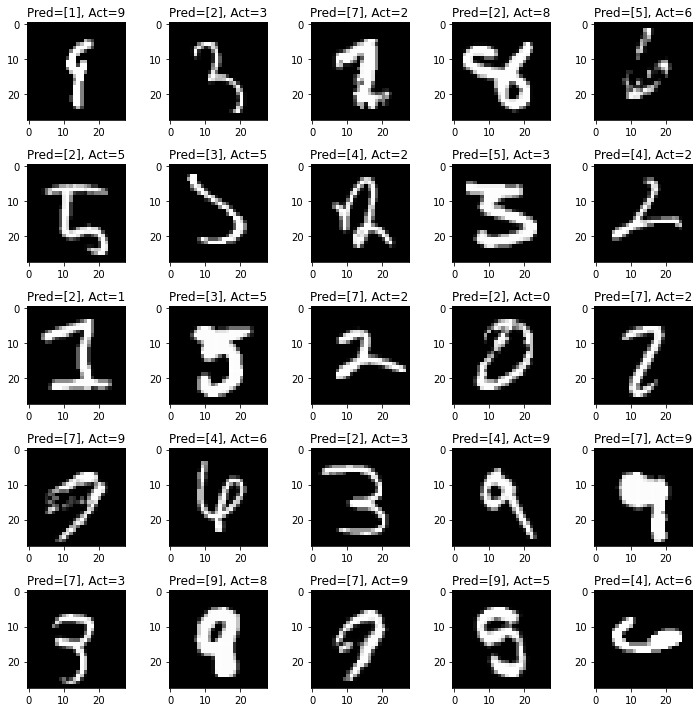

In [14]:
run_nn(enableGBN = False, L1 = False, L2 = False)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.11572039127349854 Batch_id=468 Accuracy=87.09: 100%|██████████| 469/469 [00:22<00:00, 20.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0763, Accuracy: 9809/10000 (98.09%)

EPOCH: 2


Loss=0.08421749621629715 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:22<00:00, 21.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0553, Accuracy: 9861/10000 (98.61%)

EPOCH: 3


Loss=0.05482467636466026 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:22<00:00, 20.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0657, Accuracy: 9846/10000 (98.46%)

EPOCH: 4


Loss=0.1916559338569641 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:22<00:00, 21.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9884/10000 (98.84%)

EPOCH: 5


Loss=0.1541169285774231 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:22<00:00, 21.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9885/10000 (98.85%)

EPOCH: 6


Loss=0.1443016082048416 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:22<00:00, 20.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1095, Accuracy: 9728/10000 (97.28%)

EPOCH: 7


Loss=0.05758395791053772 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:22<00:00, 20.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9930/10000 (99.30%)

EPOCH: 8


Loss=0.051855284720659256 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.03607357665896416 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:22<00:00, 21.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.09593959897756577 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:22<00:00, 21.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.10645272582769394 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:22<00:00, 20.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.09111678600311279 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.0694880485534668 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:22<00:00, 20.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.14103783667087555 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:22<00:00, 20.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.08068177849054337 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:22<00:00, 21.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9937/10000 (99.37%)

EPOCH: 16


Loss=0.08019373565912247 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:22<00:00, 20.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9936/10000 (99.36%)

EPOCH: 17


Loss=0.06281707435846329 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Loss=0.0493689589202404 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:22<00:00, 20.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.0574045330286026 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9932/10000 (99.32%)

EPOCH: 20


Loss=0.06017196178436279 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:22<00:00, 20.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.09377650171518326 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:22<00:00, 20.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9935/10000 (99.35%)

EPOCH: 22


Loss=0.08784282207489014 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:22<00:00, 20.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9936/10000 (99.36%)

EPOCH: 23


Loss=0.1209598183631897 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:22<00:00, 20.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9935/10000 (99.35%)

EPOCH: 24


Loss=0.12061834335327148 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:22<00:00, 20.79it/s]



Test set: Average loss: 0.0269, Accuracy: 9937/10000 (99.37%)



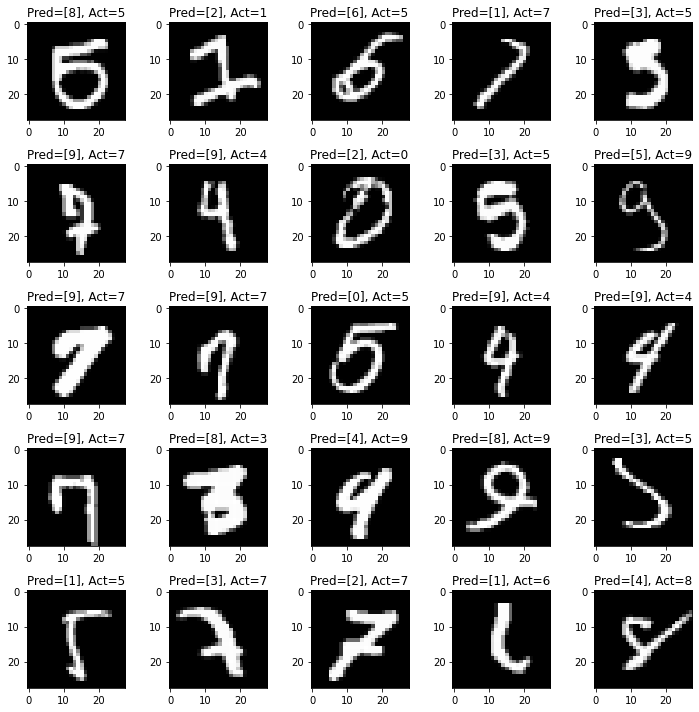

In [15]:
run_nn(enableGBN = True, L1 = False, L2 = False)

In [16]:
run_nn(enableGBN = False, L1 = True, L2 = False)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.12702518701553345 Batch_id=468 Accuracy=86.29: 100%|██████████| 469/469 [00:26<00:00, 17.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0999, Accuracy: 9758/10000 (97.58%)

EPOCH: 2


Loss=0.08357524126768112 Batch_id=468 Accuracy=97.51: 100%|██████████| 469/469 [00:26<00:00, 17.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0775, Accuracy: 9810/10000 (98.10%)

EPOCH: 3


Loss=0.09029349684715271 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:27<00:00, 17.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0659, Accuracy: 9862/10000 (98.62%)

EPOCH: 4


Loss=0.11083260178565979 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:26<00:00, 17.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0620, Accuracy: 9878/10000 (98.78%)

EPOCH: 5


Loss=0.09177416563034058 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:27<00:00, 17.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0646, Accuracy: 9851/10000 (98.51%)

EPOCH: 6


Loss=0.04464027285575867 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:26<00:00, 17.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0774, Accuracy: 9802/10000 (98.02%)

EPOCH: 7


Loss=0.05285400524735451 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:26<00:00, 17.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9935/10000 (99.35%)

EPOCH: 8


Loss=0.029413077980279922 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:27<00:00, 17.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9937/10000 (99.37%)

EPOCH: 9


Loss=0.04287612810730934 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:26<00:00, 17.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9941/10000 (99.41%)

EPOCH: 10


Loss=0.023557983338832855 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:26<00:00, 17.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9940/10000 (99.40%)

EPOCH: 11


Loss=0.03565378487110138 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:26<00:00, 17.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


Loss=0.053904615342617035 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:26<00:00, 17.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9938/10000 (99.38%)

EPOCH: 13


Loss=0.037166595458984375 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:26<00:00, 17.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


Loss=0.06119804456830025 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:26<00:00, 17.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9943/10000 (99.43%)

EPOCH: 15


Loss=0.026723021641373634 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:26<00:00, 17.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9941/10000 (99.41%)

EPOCH: 16


Loss=0.03763028234243393 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:27<00:00, 17.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9943/10000 (99.43%)

EPOCH: 17


Loss=0.04335847869515419 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:27<00:00, 17.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9945/10000 (99.45%)

EPOCH: 18


Loss=0.030191974714398384 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:27<00:00, 17.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9945/10000 (99.45%)

EPOCH: 19


Loss=0.06119849160313606 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:27<00:00, 17.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9945/10000 (99.45%)

EPOCH: 20


Loss=0.1054825410246849 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:27<00:00, 17.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9945/10000 (99.45%)

EPOCH: 21


Loss=0.07589973509311676 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:27<00:00, 17.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9946/10000 (99.46%)

EPOCH: 22


Loss=0.0825730487704277 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:27<00:00, 17.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9945/10000 (99.45%)

EPOCH: 23


Loss=0.04648834839463234 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:27<00:00, 17.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9946/10000 (99.46%)

EPOCH: 24


Loss=0.046945031732320786 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:27<00:00, 17.21it/s]



Test set: Average loss: 0.0283, Accuracy: 9946/10000 (99.46%)



In [17]:
run_nn(enableGBN = True, L1 = True, L2 = False)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.1422526091337204 Batch_id=468 Accuracy=86.28: 100%|██████████| 469/469 [00:27<00:00, 16.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0949, Accuracy: 9746/10000 (97.46%)

EPOCH: 2


Loss=0.13136513531208038 Batch_id=468 Accuracy=96.66: 100%|██████████| 469/469 [00:28<00:00, 16.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0772, Accuracy: 9805/10000 (98.05%)

EPOCH: 3


Loss=0.0596005879342556 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:28<00:00, 16.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0617, Accuracy: 9842/10000 (98.42%)

EPOCH: 4


Loss=0.05547890067100525 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:28<00:00, 16.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0552, Accuracy: 9861/10000 (98.61%)

EPOCH: 5


Loss=0.06692906469106674 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:28<00:00, 16.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0587, Accuracy: 9859/10000 (98.59%)

EPOCH: 6


Loss=0.11844934523105621 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:28<00:00, 16.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0601, Accuracy: 9859/10000 (98.59%)

EPOCH: 7


Loss=0.03840265050530434 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:28<00:00, 16.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9926/10000 (99.26%)

EPOCH: 8


Loss=0.07557165622711182 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:28<00:00, 16.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9939/10000 (99.39%)

EPOCH: 9


Loss=0.036751773208379745 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:28<00:00, 16.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9933/10000 (99.33%)

EPOCH: 10


Loss=0.06536421179771423 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:28<00:00, 16.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.0890868529677391 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:28<00:00, 16.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.12157110869884491 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:28<00:00, 16.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.06541376560926437 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:28<00:00, 16.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.14424096047878265 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:28<00:00, 16.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9937/10000 (99.37%)

EPOCH: 15


Loss=0.06640180200338364 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:28<00:00, 16.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9936/10000 (99.36%)

EPOCH: 16


Loss=0.07553807646036148 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:28<00:00, 16.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.07855060696601868 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:28<00:00, 16.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.11473901569843292 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:28<00:00, 16.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9933/10000 (99.33%)

EPOCH: 19


Loss=0.11431996524333954 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:28<00:00, 16.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9935/10000 (99.35%)

EPOCH: 20


Loss=0.06286074966192245 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:28<00:00, 16.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9931/10000 (99.31%)

EPOCH: 21


Loss=0.07235129177570343 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:28<00:00, 16.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9931/10000 (99.31%)

EPOCH: 22


Loss=0.06770098954439163 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:28<00:00, 16.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9935/10000 (99.35%)

EPOCH: 23


Loss=0.04646867513656616 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:28<00:00, 16.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9935/10000 (99.35%)

EPOCH: 24


Loss=0.045475803315639496 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:28<00:00, 16.61it/s]



Test set: Average loss: 0.0292, Accuracy: 9935/10000 (99.35%)



In [18]:
run_nn(enableGBN = False, L1 = False, L2 = True)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.22453124821186066 Batch_id=468 Accuracy=87.16: 100%|██████████| 469/469 [00:21<00:00, 21.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0735, Accuracy: 9819/10000 (98.19%)

EPOCH: 2


Loss=0.04423603042960167 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:21<00:00, 21.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9892/10000 (98.92%)

EPOCH: 3


Loss=0.043309494853019714 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:21<00:00, 21.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9866/10000 (98.66%)

EPOCH: 4


Loss=0.035315677523612976 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:21<00:00, 21.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9915/10000 (99.15%)

EPOCH: 5


Loss=0.03804653882980347 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:21<00:00, 21.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9925/10000 (99.25%)

EPOCH: 6


Loss=0.0429634265601635 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:21<00:00, 21.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.06504664570093155 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)

EPOCH: 8


Loss=0.07020283490419388 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:21<00:00, 21.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9935/10000 (99.35%)

EPOCH: 9


Loss=0.04414805769920349 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:21<00:00, 21.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.008021186105906963 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:21<00:00, 21.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9940/10000 (99.40%)

EPOCH: 11


Loss=0.016327202320098877 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:21<00:00, 21.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.039957236498594284 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:21<00:00, 21.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9940/10000 (99.40%)

EPOCH: 13


Loss=0.062344685196876526 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:22<00:00, 21.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9944/10000 (99.44%)

EPOCH: 14


Loss=0.02342962473630905 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9940/10000 (99.40%)

EPOCH: 15


Loss=0.04549963399767876 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:21<00:00, 21.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9937/10000 (99.37%)

EPOCH: 16


Loss=0.004353140946477652 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9938/10000 (99.38%)

EPOCH: 17


Loss=0.015446196310222149 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Loss=0.017834484577178955 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


Loss=0.005696376319974661 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9938/10000 (99.38%)

EPOCH: 20


Loss=0.06611771136522293 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:21<00:00, 21.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9938/10000 (99.38%)

EPOCH: 21


Loss=0.008107979781925678 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9941/10000 (99.41%)

EPOCH: 22


Loss=0.03035157360136509 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:22<00:00, 20.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9943/10000 (99.43%)

EPOCH: 23


Loss=0.055436935275793076 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:23<00:00, 20.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9943/10000 (99.43%)

EPOCH: 24


Loss=0.018229475244879723 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:22<00:00, 21.00it/s]



Test set: Average loss: 0.0205, Accuracy: 9941/10000 (99.41%)



In [19]:
run_nn(enableGBN = True, L1 = False, L2 = True)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.22100567817687988 Batch_id=468 Accuracy=85.87: 100%|██████████| 469/469 [00:23<00:00, 19.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0671, Accuracy: 9824/10000 (98.24%)

EPOCH: 2


Loss=0.06682083755731583 Batch_id=468 Accuracy=96.78: 100%|██████████| 469/469 [00:23<00:00, 20.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9859/10000 (98.59%)

EPOCH: 3


Loss=0.06164524331688881 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:24<00:00, 18.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.10377655178308487 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:24<00:00, 19.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9909/10000 (99.09%)

EPOCH: 5


Loss=0.04781356453895569 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:23<00:00, 19.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.04530017450451851 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:24<00:00, 19.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.061490144580602646 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:24<00:00, 19.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)

EPOCH: 8


Loss=0.0377839170396328 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:23<00:00, 19.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

EPOCH: 9


Loss=0.0207451730966568 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:23<00:00, 19.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9935/10000 (99.35%)

EPOCH: 10


Loss=0.04717083275318146 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:23<00:00, 19.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9939/10000 (99.39%)

EPOCH: 11


Loss=0.06917595863342285 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:24<00:00, 19.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.021104702726006508 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:24<00:00, 19.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.009852726943790913 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:23<00:00, 19.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.05697806552052498 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:23<00:00, 19.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9937/10000 (99.37%)

EPOCH: 15


Loss=0.013306275010108948 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:23<00:00, 19.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9938/10000 (99.38%)

EPOCH: 16


Loss=0.08105021715164185 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:23<00:00, 19.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9937/10000 (99.37%)

EPOCH: 17


Loss=0.0324619822204113 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:23<00:00, 20.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Loss=0.00901241134852171 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:23<00:00, 20.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9938/10000 (99.38%)

EPOCH: 19


Loss=0.055846720933914185 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:23<00:00, 20.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9936/10000 (99.36%)

EPOCH: 20


Loss=0.07264991849660873 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:23<00:00, 20.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9937/10000 (99.37%)

EPOCH: 21


Loss=0.025092443451285362 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:23<00:00, 20.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9936/10000 (99.36%)

EPOCH: 22


Loss=0.014618848450481892 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:23<00:00, 20.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9938/10000 (99.38%)

EPOCH: 23


Loss=0.08510252833366394 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:23<00:00, 19.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9939/10000 (99.39%)

EPOCH: 24


Loss=0.02866973541676998 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:23<00:00, 20.25it/s]



Test set: Average loss: 0.0186, Accuracy: 9939/10000 (99.39%)



In [20]:
run_nn(enableGBN = False, L1 = True, L2 = True)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.11423985660076141 Batch_id=468 Accuracy=87.98: 100%|██████████| 469/469 [00:28<00:00, 16.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0733, Accuracy: 9796/10000 (97.96%)

EPOCH: 2


Loss=0.05617444962263107 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:27<00:00, 16.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9826/10000 (98.26%)

EPOCH: 3


Loss=0.030595483258366585 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:27<00:00, 16.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9918/10000 (99.18%)

EPOCH: 4


Loss=0.04275238513946533 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:27<00:00, 17.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


Loss=0.07287516444921494 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:27<00:00, 17.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.053499724715948105 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:27<00:00, 17.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.021513836458325386 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:27<00:00, 17.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9926/10000 (99.26%)

EPOCH: 8


Loss=0.027047237381339073 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:27<00:00, 17.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9934/10000 (99.34%)

EPOCH: 9


Loss=0.018780013546347618 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:27<00:00, 17.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.00924188643693924 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:27<00:00, 17.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.011229179799556732 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:27<00:00, 17.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.01650412008166313 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:27<00:00, 17.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.013458501547574997 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:27<00:00, 17.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.009684301912784576 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:27<00:00, 17.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Loss=0.041887298226356506 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:27<00:00, 17.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.006848189048469067 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:27<00:00, 17.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9937/10000 (99.37%)

EPOCH: 17


Loss=0.015557870268821716 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:27<00:00, 17.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Loss=0.04489050805568695 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:27<00:00, 17.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.02325848862528801 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:27<00:00, 17.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9934/10000 (99.34%)

EPOCH: 20


Loss=0.02761441096663475 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:27<00:00, 17.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9935/10000 (99.35%)

EPOCH: 21


Loss=0.01888224482536316 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:27<00:00, 17.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99.39%)

EPOCH: 22


Loss=0.05312160775065422 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:27<00:00, 16.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9934/10000 (99.34%)

EPOCH: 23


Loss=0.017147481441497803 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:27<00:00, 17.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9937/10000 (99.37%)

EPOCH: 24


Loss=0.05782799795269966 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:27<00:00, 17.16it/s]



Test set: Average loss: 0.0192, Accuracy: 9937/10000 (99.37%)



In [21]:
run_nn(enableGBN = True, L1 = True, L2 = True)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.16938690841197968 Batch_id=468 Accuracy=87.13: 100%|██████████| 469/469 [00:28<00:00, 16.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0605, Accuracy: 9832/10000 (98.32%)

EPOCH: 2


Loss=0.1327374130487442 Batch_id=468 Accuracy=96.90: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9873/10000 (98.73%)

EPOCH: 3


Loss=0.08811654150485992 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:28<00:00, 16.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9873/10000 (98.73%)

EPOCH: 4


Loss=0.03990672528743744 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:28<00:00, 16.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9899/10000 (98.99%)

EPOCH: 5


Loss=0.07275625318288803 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:28<00:00, 16.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9885/10000 (98.85%)

EPOCH: 6


Loss=0.02611514739692211 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:28<00:00, 16.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9920/10000 (99.20%)

EPOCH: 7


Loss=0.061520256102085114 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:28<00:00, 16.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.07045918703079224 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:28<00:00, 16.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.11604567617177963 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:28<00:00, 16.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.11409078538417816 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:28<00:00, 16.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.045894429087638855 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:28<00:00, 16.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.05184922739863396 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:28<00:00, 16.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

EPOCH: 13


Loss=0.07955332845449448 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:28<00:00, 16.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.031068095937371254 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:28<00:00, 16.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Loss=0.04844198375940323 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:28<00:00, 16.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.03615305945277214 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:28<00:00, 16.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.10784713178873062 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:28<00:00, 16.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.030311010777950287 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:28<00:00, 16.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.09494762867689133 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:28<00:00, 16.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9935/10000 (99.35%)

EPOCH: 20


Loss=0.03629128262400627 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:28<00:00, 16.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.10513361543416977 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:28<00:00, 16.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.06926415860652924 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:28<00:00, 16.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9932/10000 (99.32%)

EPOCH: 23


Loss=0.06391206383705139 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:28<00:00, 16.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9934/10000 (99.34%)

EPOCH: 24


Loss=0.09413059800863266 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:28<00:00, 16.41it/s]



Test set: Average loss: 0.0194, Accuracy: 9933/10000 (99.33%)



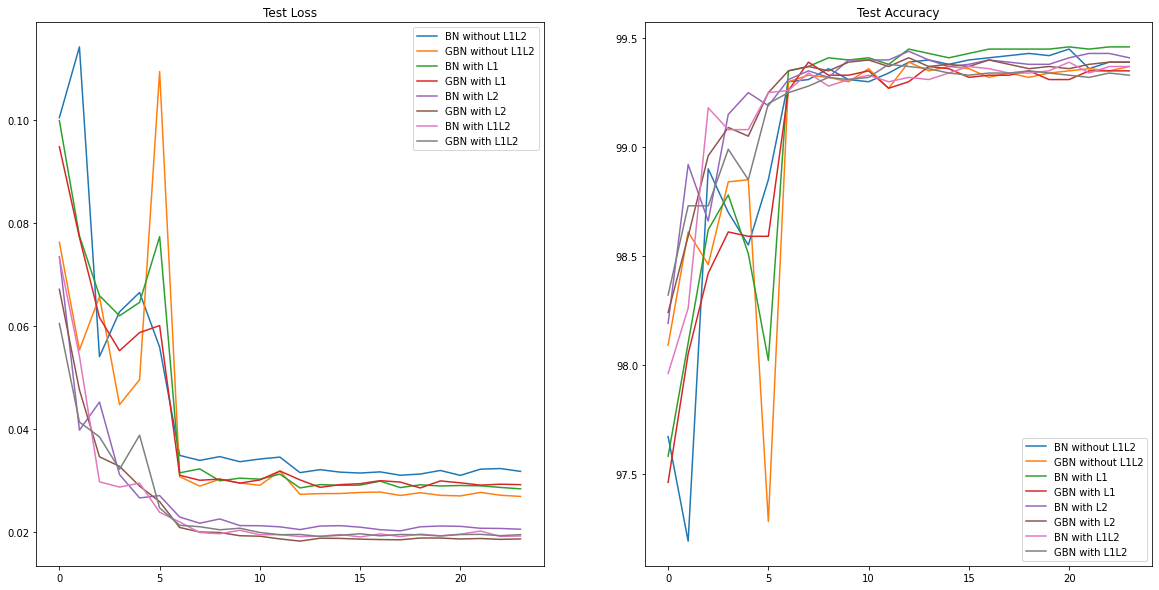

In [24]:
fig, axes = plt.subplots(1,2,figsize=(20,10))
for key in keys:
  axes[0].plot(test_losses[key], label=" ".join(key.split("_")))
  axes[0].set_title("Test Loss")
  axes[0].legend()
  axes[1].plot(test_acc[key], label=" ".join(key.split("_")))
  axes[1].set_title("Test Accuracy")
  axes[1].legend()
